# Training

In [1]:
import pandas as pd
from fastai.vision.all import *
from fastai.metrics import accuracy, error_rate
from os import walk
from os.path import relpath
from pathlib import Path
from torch import cuda

In [2]:
cuda.is_available()

True

## Load data
data can be downloaded from: https://www.kaggle.com/msambare/fer2013

In [3]:
# Images Path
root_path = Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces')
path_to_data = Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces/faces/train')

# Generate dataset
filelist = [relpath(os.path.join(dp, f), path_to_data) for dp, dn, filenames in os.walk(path_to_data) for f in filenames]
data_tuples = list(zip(filelist, [x.split("/")[0] for x in filelist]))
# .sample() randomizes dataframe order
df = pd.DataFrame(data_tuples, columns=['Path', 'Label']).sample(frac=1)
df

,Path,Label
8651,happy/Training_41716944.jpg,happy
4910,happy/Training_63637868.jpg,happy
24447,neutral/Training_91328473.jpg,neutral
27415,surprise/Training_7607871.jpg,surprise
9356,happy/Training_91698400.jpg,happy
...,...,...
747,angry/Training_19214465.jpg,angry
12679,sad/Training_27843041.jpg,sad
8080,happy/Training_92140607.jpg,happy
18571,fear/Training_77282497.jpg,fear


## Prepare data

In [4]:
dls = ImageDataLoaders.from_df(df, path_to_data, valid_pct=0.2, label_col=1, bs=64, item_tfms=Resize(192))
# dls = ImageDataLoaders.from_df(df, path_to_data, valid_pct=0.2, label_col=1, bs=64, val_bs=32, 
#                                size=128, batch_tfms=Normalize.from_stats(*imagenet_stats))

In [5]:
# Original size
dls.train_ds[0][0].shape

(48, 48)

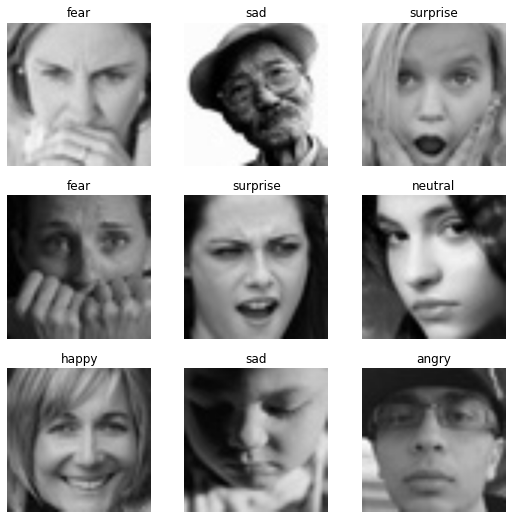

In [6]:
dls.show_batch()

## Import CNN model

In [7]:
# Choose model
arch_model = models.resnet50

In [8]:
# Build TL model based on arch
learning_model = cnn_learner(dls, arch_model, metrics=[accuracy, error_rate])

In [9]:
# learning_model.model

In [10]:
# Labels counter
from collections import Counter
labels_count = Counter(label for label in df['Label'])
labels_count

Counter({'happy': 7215,
         'neutral': 4965,
         'surprise': 3171,
         'angry': 3995,
         'fear': 4097,
         'sad': 4830,
         'disgust': 436})

In [11]:
# Get Class Weights --> This will allow us to compensate the classes with less data
# total_count = sum(labels_count.values())
# class_weights = {cls: total_count / count for cls, count in labels_count.items()}
# class_weights

class_weights = {'surprise':1.5, 'neutral':1, 'happy':1, 'angry':1.5, 'sad':1, 'fear':1.5, 'disgust':1.5}

In [12]:
weights = [*class_weights.values()]
class_weights=torch.FloatTensor(weights).cuda()
learning_model.crit = nn.CrossEntropyLoss(weight=class_weights)

## Training stage 1

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=3.630780702224001e-05)

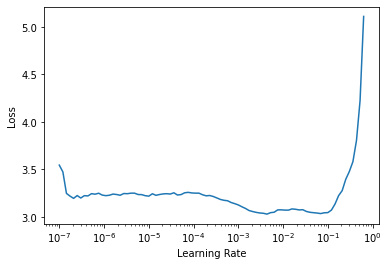

In [13]:
# LR Finder helps to pick a good learning rate
learning_model.lr_find()

In [14]:
# Train
learning_model.fit_one_cycle(6, 1e-02)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.431186,1.314220,0.519944,0.480056,05:19
1,1.239716,1.197895,0.559659,0.440341,04:01
2,1.119625,1.109313,0.569936,0.430064,04:35
3,1.019552,1.011868,0.618882,0.381118,04:33
4,0.887665,0.932884,0.658596,0.341404,04:01
5,0.756334,0.939789,0.656854,0.343146,05:04


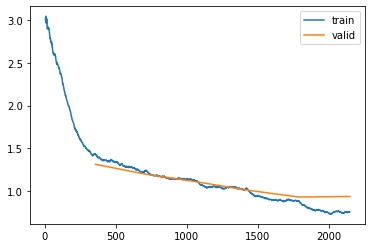

In [15]:
# Plot losses
learning_model.recorder.plot_loss()

In [16]:
# Save stage 1
# model_name = "resnet50_stage1_noNORM_184"
# learning_model.save(root_path / model_name)

## Training stage 2

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.981071586167673e-06)

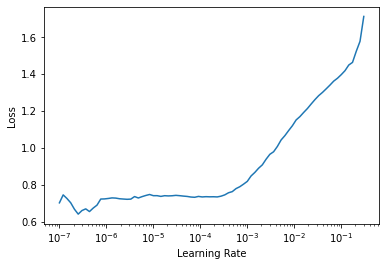

In [17]:
# Unfreeze
learning_model.unfreeze()

# Find LR
learning_model.lr_find()

In [18]:
# Train
learning_model.fit_one_cycle(3, (slice(1e-6, 1e-4)))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.741959,0.950890,0.647100,0.352900,05:54
1,0.649578,0.947814,0.656854,0.343146,06:16
2,0.559871,0.963120,0.655287,0.344713,06:05


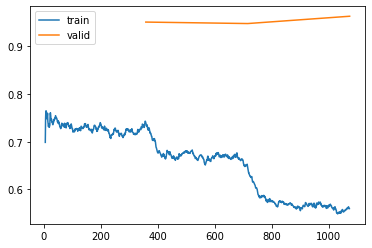

In [19]:
# Plot losses
learning_model.recorder.plot_loss()

In [20]:
# Save stage 2
# model_name = "resnet50_stage2_noNORM_184"
# learning_model.save(root_path / model_name)

In [21]:
# Remove ram stored data
del dls
del df

# Testing

In [22]:
# Images Path
path_to_test = Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces/faces/test')

# Generate dataset
filelist = [relpath(os.path.join(dp, f), path_to_test) for dp, dn, filenames in os.walk(path_to_test) for f in filenames]
data_tuples = list(zip(filelist, [x.split("/")[0] for x in filelist]))
df_test = pd.DataFrame(data_tuples, columns=['Path', 'Label'])
df_test

,Path,Label
0,angry/PublicTest_14075653.jpg,angry
1,angry/PrivateTest_73860110.jpg,angry
2,angry/PublicTest_18274972.jpg,angry
3,angry/PublicTest_14798104.jpg,angry
4,angry/PublicTest_51080774.jpg,angry
...,...,...
7173,surprise/PublicTest_17911043.jpg,surprise
7174,surprise/PublicTest_83231837.jpg,surprise
7175,surprise/PrivateTest_95778572.jpg,surprise
7176,surprise/PrivateTest_81533064.jpg,surprise


In [23]:
# Generate test_dataloader
dls_test = ImageDataLoaders.from_df(df_test, path_to_test, valid_pct=0.2, label_col=1, bs=64, item_tfms=Resize(240))

In [24]:
# Switch train_dataloader to test_dataloader 
learning_model.dls = dls_test
arr = learning_model.validate()
print("Accuracy: " str(arr[1]))

# Switch test_dataloader to train_dataloader 
# learning_model.dls = dls
# arr = learning_model.validate()
# arr

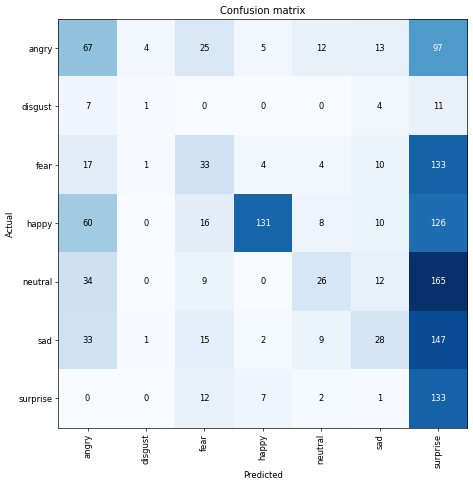

In [25]:
interp = ClassificationInterpretation.from_learner(learning_model)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

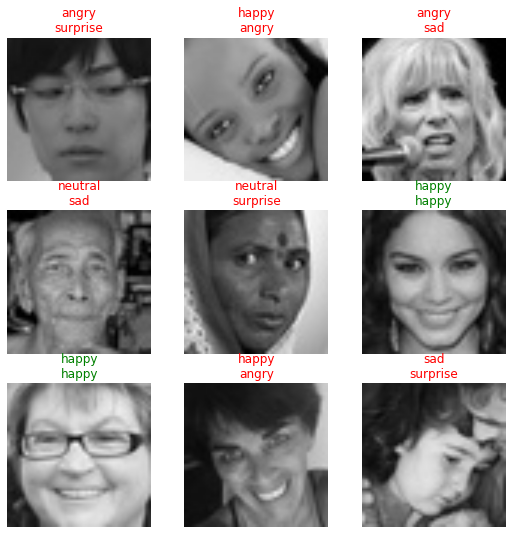

In [26]:
learning_model.show_results()

In [27]:
# learning_model.__dict__